## Equações de Bellman dos jogadores para o modelo de Dou et al (2020)

Parâmetros iguais aos de Dou et. al (2020)

T = 13

Arrays com valores de continuação são preenchidos desde t = 0 até t = T


**Experimento**:
Valor de reorganização da firma avaliado na habilidade AMANHA: $U_{t}(\theta_{t+1})$
E com valor de reorganização em resposta à liquidação também avaliado AMANHA: $U_{t}(\theta_{t+1})$


In [1]:
#para mostrar todos os resultados e não apenas o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numba as nb
from numba import jit, njit, jitclass, prange, float64, int32
%matplotlib inline


import time

### Parâmetros do jogo

In [3]:
μ = float64(4.566) #número de meses entre períodos, traduz a quantidade de períodos t em quantidade de meses
ρ = float64(0.884) # (1 - ρ) é a taxa de depreciação da empresa a cada período
# ρ = float64(0.5) #testando nova taxa de depreciação
β = float64(9.84) #inverso da velocidade de aprendizado
c0 = float64(0.044) #custo fixo de ir para a corte
c1 = float64(0.015) #custo variável de ir para a corte


hs0 = float64(0.28) #habilidade inicial de s
hj0 = float64(0.36) #habilidade inicial de j

λj = float64(0.346)



Valores que virão dos dados

In [4]:
Vmax = float64(1.0) #valor máximo de reorganização da firma
L = float64(0.25) #valor inicial de liquidação da firma
Ds = float64(0.32) #valor da dívida com credor sênior
Dj = float64(0.68) #valor da dívida com credor júnior

D = Ds + Dj #valor total da dívida, usada para escalar custos


Definições iniciais: custo, valores de liquidação, valor máximo de reorganização da firma a cada período, número de rounds

In [5]:
#função custo
def Ct(t):
    #cost at period 0 is 0
    if(t == 0):
        return 0
    else:
        return c0 * D + c1 * t * D
    
#test
Ct(0)    
Ct(1)
Ct(2)
Ct(2) == c0 * D + c1 * (2) * D

#o fato de o custo ser função de D implica que duas empresas com mesmo valor de V e L podem ter destinos diferentes, pois
#a empresa com maior D terá maiores custos dentro da corte


0

0.059

0.074

True

#### Hipótese: a notação do paper está errada.

Vou tentar resolver supondo que quem propõe reorganização recebe o valor Ut(.) avaliado na sua habilidade do período seguinte.

A ideia é que: o credor irá reorganizar a firma usando o plano do período t, mas à tarde ele vai ter um update na habilidade. Então ele conseguirá extrair um pouco mais do valor total da firma.

###### Implicação para o período final

Seguindo isso, payoff de uma reorganização proposta na manhã de t e efetivada na tarde de t é:

$U_{t}(\theta_{K,t+1}) = \theta_{K,t+1} * V_0 * \rho^{(t-1)} - C_{t}$

Então o período final é o que não compensa mais reorganizar nem se a habilidade for igual a 1. T é definido por:

$U_{t}(\theta_{K,t+1}) = 1 * V_0 * \rho^{(t-1)} - C_{t} <= L - C_{t}$

O que implica

$V_0 * \rho^{(t-1)} <= L$


Exatamente como os autores definiram





In [6]:
#number of periods
def max_turns(Vmax, L, ρ):
    t = 0
    
    while(ρ**(t-1) * Vmax > L):
        t += 1
    return t


T = max_turns(Vmax, L, ρ)
T

13

In [7]:
#testando se T é o período final mesmo
t = T
ρ**(t-1) * Vmax - Ct(t) > L - Ct(t)


t = T-1
ρ**(t-1) * Vmax - Ct(t) > L - Ct(t)


#to see the values
t = T-1
ρ**(t-1) * Vmax - Ct(t)

L - Ct(t)

False

True

0.03361723529489924

0.026000000000000023

In [8]:
#value of the firm in each period

def Vt(Vmax, Tmax, ρ):
    
    V = np.empty(Tmax+1)
    
    V[0] = Vmax
    
    #range exclui o valor máximo, daí que eu adicionei 1
    for t in range(1, Tmax+1):
        V[t] = Vmax * ρ**(t-1)
        
    return V

V = Vt(Vmax, T, ρ)

V - Ct(T)
L - Ct(T)

V.size


array([ 0.761     ,  0.761     ,  0.645     ,  0.542456  ,  0.4518071 ,
        0.37167348,  0.30083536,  0.23821445,  0.18285758,  0.1339221 ,
        0.09066314,  0.05242221,  0.01861724, -0.01126636])

0.01100000000000001

14

In [9]:
#array with cost of reorganization each period

C = np.empty(T+1)

for t in range(T+1):
    C[t] = Ct(t)
    
C
C.size

array([0.   , 0.059, 0.074, 0.089, 0.104, 0.119, 0.134, 0.149, 0.164,
       0.179, 0.194, 0.209, 0.224, 0.239])

14

In [10]:
#valores de liquidação

def s_L(t):
    
    return np.minimum(L - Ct(t), Ds)

s_L(0)
s_L(1)


def j_L(t):
    
    return np.minimum(L - Ct(t) - s_L(t), Dj)
    
j_L(0)

0.25

0.191

0.0

Habilidades possíveis dos jogadores e funções de massa de probabilidade

In [11]:
#grid size
grid = 100

hlow = 0.01
hhigh = 1.0

#começa no menor valor possível, vai até o maior valor possível num intervalo do tamanho do grid
hvals = np.linspace(hlow, hhigh, grid)

hvals
hvals[6]


array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

0.06999999999999999

In [12]:
#array to tell us the size of the pie at period t
#arguments: (period, θk,t)
U = np.zeros((T+1, grid))


U = (hvals[:,None] * V[None,:] - C).T

U.shape

#value of proposing reorganization at t ####

#if t==0, then there are no costs
U[0,7] == hvals[7] * V[0]

U[0, 7] == hvals[7] * Vmax

#if t>0, there are costs
U[1,0] == hvals[0] * V[1] - Ct(1)


U[2,5] == hvals[5] * V[2] - Ct(2)

#checking the last period
#t = T
U[T,7] ==  hvals[7] * V[T] - Ct(T)


(14, 100)

True

True

True

True

True

Testando se o python consegue criar 2 x 10 arrays para os valores de continuação:
* 2 porque temos s e j
* 10 porque seria a quantidade de clusters

Se não conseguir, precisaremos pensar numa maneira de economizar memória no futuro

#test
test_W = np.zeros((2, 10, T, grid, grid, grid))

test_W.shape

In [13]:
def cdf(x, lt):
    
    #return the cdf of x given the lower bound lt
    #geq than 1 because of our discretization method 
    if(x >= 1):
        
        return 1
    
    else:
        
        if(x >= lt):
            return 1 - ((1-x)**β)/((1-lt)**β)
        else:
            return 0
        
#test      
cdf(0.5, 1)
cdf(0.5, 0.4)
            
cdf(0.99, 0.01)

cdf(1, 0.01)

cdf(1, 0.9)

0

0.8337136736331454

1.0

1

1

array([4.86020895e-02, 9.08895313e-02, 8.30118688e-02, 7.57457990e-02,
       6.90494782e-02, 6.28835322e-02, 5.72109337e-02, 5.19968857e-02,
       4.72087086e-02, 4.28157326e-02, 3.87891938e-02, 3.51021351e-02,
       3.17293115e-02, 2.86470984e-02, 2.58334046e-02, 2.32675892e-02,
       2.09303814e-02, 1.88038045e-02, 1.68711028e-02, 1.51166722e-02,
       1.35259940e-02, 1.20855710e-02, 1.07828679e-02, 9.60625323e-03,
       8.54494497e-03, 7.58895834e-03, 6.72905635e-03, 5.95670278e-03,
       5.26401751e-03, 4.64373419e-03, 4.08916006e-03, 3.59413791e-03,
       3.15301007e-03, 2.76058433e-03, 2.41210176e-03, 2.10320626e-03,
       1.82991596e-03, 1.58859611e-03, 1.37593361e-03, 1.18891310e-03,
       1.02479441e-03, 8.81091376e-04, 7.55552069e-04, 6.46140160e-04,
       5.51017531e-04, 4.68528017e-04, 3.97182210e-04, 3.35643301e-04,
       2.82713883e-04, 2.37323685e-04, 1.98518169e-04, 1.65447963e-04,
       1.37359070e-04, 1.13583812e-04, 9.35324776e-05, 7.66856178e-05,
      

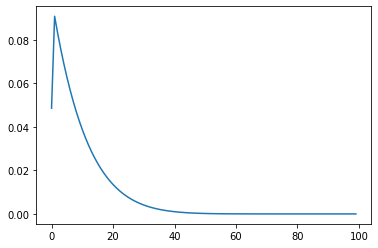

In [14]:
#nova versão da função pmf: agora cada ponto do grid é o centro da cdf
def pmf_cdf(lt, δ = hlow/2):
    
    pmf = np.empty(grid)
    
    for i, h in enumerate(hvals):
        pmf[i] = cdf(h+δ, lt) - cdf(h-δ, lt)
    
    return pmf


lt = 0.01
pmf_cdf(lt)
plt.plot(pmf_cdf(lt))

In [15]:
#gerando as pmfs

#probability mass function
pmf = np.empty((grid,grid))


for t, θt in enumerate(hvals):
    pmf[t,:] = pmf_cdf(θt)
    
#precisamos de uma pmf para quando temos lkt e queremos saber θk,t+1
#chamaremos de pmf2
pmf2 = np.empty((grid, grid))

for i in range(len(hvals)):
    for j in range(len(hvals)):
        pmf2[i, j] = np.sum(np.multiply(pmf[i, :], pmf[:, j]))


Arrays dos valores de continuação dos jogadores

In [16]:
#continuation values
#period t (not t+1), θkt, ℓkt, ℓmt
s_W = np.zeros((T+1, grid, grid, grid))
j_W = np.copy(s_W)


#optimal payments
#period, θkt, ℓmt, outputs
Pst_array = np.zeros((T, grid, grid, 6))
Pjt_array = np.copy(Pst_array)

In [17]:
#populating the last period with the liquidation values
s_W[T, ...] = s_L(T)
j_W[T, ...] = j_L(T)

Funções para calcular os valores de continuação dos jogadores

In [18]:
#função para mapear os valores das habilidades aos arrays
@njit
def find(h):
    
    return np.searchsorted(hvals, h)

find(hvals[7])
type(find(hvals[7]))

find(hvals)

#checando se temos valores repetidos
count = np.bincount(find(hvals))
np.where(count > 1)

7

int

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

(array([], dtype=int64),)

In [19]:
#função cutoff

@njit
def cutoff_m(t, Pkt, hkt, lmt, m_W):
    
    cmt = find(lmt)
    
    while(Pkt > m_W[t+1, cmt, cmt, find(hkt)] and hvals[cmt] < hhigh):
        cmt += 1
            
    #returns the index of the cutoff
    return max(int32(cmt), find(lmt))

#deve retornar 99, pois o valor de continuação de j no final é zero
cutoff_m(T-1, 0.01, 0.5, 0.4, j_W)

99

#function to select the pmf function with a update


def h_m(t, cutoff_m, lmt):
    #takes the indexes of cutoff and lmt
    #if cutoff > lmt, pmf[cutoff]
    #otherwise, pmf2[lmt]
    
    if(cutoff_m > lmt):
        return pmf[cutoff_m, lmt:] #'lmt:' is to make sure the dimensions are ok

    else:
        
    #at t=0, all information is symmetric, so we use pmf instead of pmf2
        if(t == 0):
            return pmf[lmt, lmt:]
        else:
            return pmf2[lmt, lmt:]

#test
#t != 0
h_m(1, 49,50) == pmf2[50, 50:]
h_m(1, 99, 50) == pmf[99, 50:]


#t == 0
h_m(0, 49, 50) == pmf[50, 50:]
h_m(0, 99, 50) == pmf[99, 50:]

In [20]:
#function to select the pmf function as it is writen in the paper

def h_m(t, cutoff_m, lmt):
    #takes the indexes of cutoff and lmt
        
    #at t=0, all information is symmetric, so we use pmf instead of pmf2
    if(t == 0):
        return pmf[lmt, lmt:]
    else:
        return pmf2[lmt, lmt:]
    
#test
h_m(0, 49,50) == pmf[50, 50:]
h_m(1, 99, 50) == pmf2[50, 50:]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [21]:
#função payoff ótimo

#retorna a política ótima também

step_size = 1
share = np.arange(0, hhigh, hlow/step_size)
#Pkt versão 6: propostas são share da habilidade de hoje
#Pkt versão 7: valor de continuação do adversário dividido entre ANTES e DEPOIS do cutoff de screening
#Pkt versão 8: considerando que o valor da torta em t é θkt * Vt
def Pkt(t, hkt, lmt, k_W, m_W, k_L):
    
    #new grid of payments is the share of the pie tomorrow based on the hability today
    Pkt_grid = np.empty(share.size + 1)

    #the first possible value is -Vmax, which is an offer so low that will be rejected for sure (waiting offer)
    Pkt_grid[0] = -Vmax

    #the other values are the possible shares of the pie today
    Pkt_grid[1:] = U[t, find(hkt)] * share


    #descartando os valores que são menores que o menor valor de continuação possível do adversário
    #assim não confundiremos uma proposta de reorganização com uma de espera
    lowest = m_W[t+1, find(lmt), find(lmt), find(hkt)]
    Pkt_grid[1:] = np.where(Pkt_grid[1:] < lowest, lowest, Pkt_grid[1:])

    cutoffs = int32(np.empty(Pkt_grid.shape))

    #loop for calculating the cutoffs
    for i, Pkt in enumerate(Pkt_grid):
        cutoffs[i] = cutoff_m(t, Pkt, hkt, lmt, m_W)

    #     breakpoint()


    #cálculo de E1####




    #array com as probabilidades

    #probabilidade de m amanhã, dado o lower bound hoje ou o cutoff hoje

    #shape is Pkt x M
    probm = np.empty((Pkt_grid.size, hvals[find(lmt):].size))

    for i in range(Pkt_grid.size):
        probm[i] = h_m(t, cutoffs[i], find(lmt))


    #probabiilidades de k amanhã dado a habilidade verdadeira hoje. 
    probk = pmf[find(hkt),find(hkt):]



    #payoff if the proposal is accepted
    if(t==0):
        
        pE1 = np.array(U[t, find(hkt)] - Pkt_grid[:, None])
        pE1 = np.multiply(pE1, probm)
        
    else:
        #pE1[3,6] is the third possible payment combined with the sixth hability above hkt
        pE1 = np.array(U[t, None, find(hkt):] - Pkt_grid[:, None])


        #multiplicando pE1 pelas probabilides das habilidades futuras de k
        pE1 = np.multiply(pE1, probk[None, :])
        pE1 = np.sum(pE1, axis = 1)

        #ponderação pelas probabilidades de m
        pE1 = np.multiply(pE1[:, None], probm)


    #indicator array
    cont_vals = np.empty((len(Pkt_grid), hvals[find(lmt):].size))

    #continuation values separated before and after screening cutoff
    for i in range(len(Pkt_grid)):
        cont_vals[i, :(cutoffs[i]-find(lmt))] = m_W[t+1, find(lmt):cutoffs[i], find(lmt), find(hkt)]
        cont_vals[i, (cutoffs[i]-find(lmt)):] = m_W[t+1, cutoffs[i]:, cutoffs[i], find(hkt)]

    IE1 = np.where(cont_vals <= Pkt_grid[:,None] , 1, 0)


    #     breakpoint()

    #payoff de E1
    E1 = np.multiply(pE1, IE1)

    #soma ao longo das colunas (axis = 1) para que cada linha tenha o payoff esperado de propor um pagamento aceitável
    E1 = np.sum(E1, axis = 1)


    # #cálculo de E2####

    #E2 payoff can use the cutoffs directly, i.e., doesn't need to separate before and after cutoff
    #this is because pE2 will only happen if M declines the offer, which only happens if his ability is above the cutoff

    pE2 = k_W[t+1, find(hkt):, find(hkt), cutoffs]

    #multiplicando pE2 pelo array de probabilidades
    pE2 = np.multiply(pE2, probk[None, :])
    pE2 = np.sum(pE2, axis = 1)

    pE2 = np.multiply(pE2[:,None], probm)


    #indicator array
    IE2 = np.where(IE1 == 1, 0, 1)


    #payoff
    E2 = np.multiply(pE2, IE2)
    E2 = np.sum(E2, axis = 1)


    #matriz dos payoffs####
    matrix_payoff = E1 + E2

    payoff_reorg = np.max(matrix_payoff)
    index = np.argmax(matrix_payoff)

    pagamento = Pkt_grid[index]


    #calculating the optimal policy between liquidating, reorganizing or waiting ####
    payoff_liq = k_L(t)

    #waiting payoff is associated with the first possible payment, the waiting offer(-Vmax)
    payoff_wait = matrix_payoff[0]


    payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
    policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))
                         
    #retorna o payoff de esperar também para facilitar a verificação do código
    return pagamento, cutoffs[index], payoff_reorg, payoff_wait, payoff_max, policy
        
#testing hk = 0.5
t, hkt, lmt, k_W, m_W, k_L = T-1, 0.5, 0.6, s_W, j_W, s_L
Pkt(t, hkt, lmt, k_W, m_W, k_L)


#testing hk = 1
t, hkt, lmt, k_W, m_W, k_L = T-1, 1, 0.6, s_W, j_W, s_L
Pkt(t, hkt, lmt, k_W, m_W, k_L)


#testing t==0
t, hkt, lmt, k_W, m_W, k_L = 0, 0.5, 0.6, s_W, j_W, s_L
Pkt(t, hkt, lmt, k_W, m_W, k_L)



(-1.0, 59, 0.01100000000000002, 0.01100000000000002, 0.026000000000000023, 0)

(0.0, 59, 0.03361723529489926, 0.011000000000000017, 0.03361723529489926, 2)

(0.0, 59, 0.5, 0.0, 0.5, 2)

In [22]:
def Pst(t, θst, ℓjt):
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L)


def Pjt(t, θjt, ℓst):
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L)

In [23]:
#populando as matrizes para continuar os testes
t = T-1
for h in hvals:
    for l in hvals:
            Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
            Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)

In [24]:
#checando se populou ok
t, h, l = T-1, 0.5, 0.5
Pst_array[t, find(h), find(l),:] == Pst(t, h, l)

array([ True,  True,  True,  True,  True,  True])

In [25]:
#função da proposta ótima


def propose(t, hkt, lkt, lmt, Pkt_array):
    #apenas busca o valor de Pkt
    
    payoff_max, policy = Pkt_array[t, find(hkt), find(lmt)][-2:]
    
    return payoff_max, policy

#test with hk = 0.5
t, hkt, lkt, lmt, Pkt_array = T-1, 0.5, 0.01, 0.5, Pst_array

Pst_array[t, find(hkt), find(lmt), :] = Pkt(t, hkt, lmt, k_W, m_W, k_L)

propose(t, hkt, lkt, lmt, Pkt_array)


#test with hk = 1
t, hkt, lkt, lmt, Pkt_array = T-1, 1, 0.01, 0.5, Pst_array

propose(t, hkt, lkt, lmt, Pkt_array)

(0.026000000000000023, 0.0)

(0.03361723529489928, 2.0)

In [26]:
#"cdf" for the discretized distribution

def cdf_discrete(x, lt):
    #returns the probability that θt takes a value less than x, given lt
    #we use strictly less than x because of the payment offer threshold
    return np.sum(pmf[find(lt), :find(x)])


#test
cdf(0.5, 0.01)
cdf_discrete(0.5, 0.01)

0.998795478578984

0.998671575594218

In [27]:
#função de threshold

def threshold_m(t, lkt, lmt, Pmt_array):
    
    #procura onde a última entrada é diferente de 0 (policy de liquidar a firma)
    threshold_vector = np.array(np.where(Pmt_array[t, :, find(lkt), -1] != 0.0))
#     breakpoint()
    if(threshold_vector.size == 0):
        #threshold does not exist
        print("error in threshold, no payment offer found")
        
    else:
        ts = hvals[np.min(threshold_vector)]
    
        #probability that m will propose liquidation next period
        #at t==0, the info is symmetric, so lmt == θmt, thus it becomes an indicator function
        if(t==0):
            if(lmt >=ts):
                probm_liq = 0.0
            else:
                probm_liq = 1.0
            
            
        else:#if t>0

            if(lmt >= ts):
                probm_liq = 0.0
            else:
                probm_liq = cdf_discrete(ts,lmt)

    #returns the reorganization threshold and the probability that m will propose liquidation in t
    return ts, probm_liq
    

    

 
t, lkt,lmt, Pmt_array = T-1, 0.5,0.51, Pst_array

Pmt_array[t, :, find(lkt), -1]

threshold_m(t, lkt,lmt,  Pmt_array)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2.])

(0.97, 0.999999999994727)

In [28]:
#payoff esperado de responder a uma proposta de reorganização

def respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W):
    ts, probm_liq = threshold_m(t, lkt, lmt, Pmt_array)
    
    lmt = max(ts, lmt)
    
    
    #the possible values of payment given by the opponent
    Pmt_grid = Pmt_array[t, find(lmt):, find(lkt), 0]
    cutoffs = Pmt_array[t, find(lmt):, find(lkt), 1]
    cutoffs = int32(cutoffs)


    #A1### 
    
    #payoff quando receber pagamento é melhor respota
    pA1 = Pmt_grid

    #ponderação pelas probabilidades
    probk = pmf[find(hkt), find(hkt):]
    probm = pmf[find(lmt), find(lmt):]


    #primeiro vamos ver a função indicadora
    IA1 = np.where(k_W[t+1, find(hkt):, cutoffs, np.arange(find(lmt), grid, step = 1)].T <= Pmt_grid, 1, 0)

    #IA1 tem S linhas e J colunas

    #queremos uma matriz de probabiidades com a mesma dimensão
    prob = np.outer(probk, probm)

    pA1 = np.multiply(pA1.T, prob)

    A1 = np.multiply(pA1, IA1)

    #A2####

    IA2 = np.where(IA1 == 1, 0, 1)

    pA2 = k_W[t+1, find(hkt):, cutoffs, np.arange(find(lmt), grid, step = 1)].T

    pA2 = np.multiply(pA2, prob)

    A2 = np.multiply(pA2, IA2)

    payoff = A1 + A2
    payoff = np.sum(payoff)

    #returns the expected value of answering a reorganization proposal and the probability of liquidation
    return payoff * (1.0 -probm_liq), probm_liq

#test1
t, hkt, lkt, lmt, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, Pjt_array, s_W
respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)


lmt, probm_liq = threshold_m(t, lkt, lmt, Pmt_array)
Pjt(t, lmt, lkt)


#test2
t, hkt, lkt, lmt, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, Pst_array, j_W
respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)

Pst(t, lmt, lkt)


(8.796868820049055e-10, 0.9999999200284653)

(0.01100000000000001, 49, 0.0014561045676248572, 0.0, 0.0014561045676248572, 2)

(0.0, 0.9999999999956778)

(-1.0, 49, 0.011000000000000032, 0.011000000000000032, 0.026000000000000023, 0)

In [29]:
#payoff esperado de responder a uma proposta de liquidação

def respond_liq(t, hkt, lkt, lmt, k_L, m_L):
    
    #reorganiza pagando o valor de liquidação do oponente
    #U_{t} (\theta_{t+1}) pois a habilidade será a do período seguinte
    #np.dot é multiplicação matricial
    payoff_reorg = np.dot(pmf[find(hkt), find(hkt):], U[t, find(hkt):] - m_L(t))


    
    
    payoff_liq = k_L(t)
    
    return max(payoff_liq, payoff_reorg)

#o que acontece se J propor liquidar no penúltimo período e S responder?
#hkt = 0.5
t, hkt, lkt, lmt, k_L, m_L = T-1, 0.5, 0.5, 0.5, s_L, j_L

respond_liq(t, hkt, lkt, lmt, k_L, m_L)
np.dot(pmf[find(hkt), find(hkt):], U[t, find(hkt):] - m_L(t)) #leading reorg and paying m_L(t)
k_L(t)

#hkt = 1. Como a reorg demorará um período dado que ele está respondendo, então não compensará reorganizar. OK
hkt = 1.0
respond_liq(t, hkt, lkt, lmt, k_L, m_L)
np.dot(pmf[find(hkt), find(hkt):], U[t, find(hkt):] - m_L(t))
m_L(T-1)


0.026000000000000023

-0.08332977608729224

0.026000000000000023

0.03361723529489924

0.03361723529489924

0.0

In [30]:
#payoff esperado de responder
def respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L):
    
    payoff_rreorg, probm_liq = respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)
    
    return payoff_rreorg + probm_liq * respond_liq(t, hkt, lkt, lmt, k_L, m_L)
    
t, hkt, lkt, lmt, k_L, m_L, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, s_L, j_L, Pst_array, j_W

respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L)


0.025999999999887644

In [31]:
#funções de s baseado nas funções genéricas


#Pkt(t, hkt, lmt, k_W, m_W, k_L)
def Pst(t, θst, ℓjt):
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L)

#propose(t, hkt, lkt, lmt, Pkt_array)
def s_propose(t, θst, ℓst, ℓjt):
    return propose(t, θst, ℓst, ℓjt, Pst_array)

#threshold_m(t, lkt, lmt, Pmt_array)
def threshold_j(t, ℓst, ℓjt):
    return threshold_m(t, ℓst, ℓjt, Pjt_array)

#respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)
def s_respond_reorg(t, θst, ℓst, ℓjt):
    return respond_reorg(t, θst, ℓst, ℓjt, Pjt_array, s_W)

#respond_liq(t, hkt, lkt, lmt, k_L, m_L)
def s_respond_liq(t, θst, ℓst, ℓjt):
    return respond_liq(t, θst, ℓst, ℓjt, s_L, j_L)
    
#respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L) 
def s_respond(t, θst, ℓst, ℓjt):
    return respond(t, θst, ℓst, ℓjt, Pjt_array, s_W, s_L, j_L)

In [32]:
#funções de j baseado nas funções genéricas
def Pjt(t, θjt, ℓst):
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L)

def j_propose(t, θjt, ℓjt, ℓst):
    return propose(t, θjt, ℓjt, ℓst, Pjt_array)

def threshold_s(t, ℓjt, ℓst):
    return threshold_m(t, ℓjt, ℓst, Pst_array)

def j_respond_reorg(t, θjt, ℓjt, ℓst):
    return respond_reorg(t, θjt, ℓjt, ℓst, Pst_array, j_W)

def j_respond_liq(t, θjt, ℓjt, ℓst):
    return respond_liq(t, θjt, ℓjt, ℓst, j_L, s_L)
    
def j_respond(t, θjt, ℓjt, ℓst):
    return respond(t, θjt, ℓjt, ℓst, Pst_array, j_W, j_L, s_L)

### Populando as matrizes do jogo

##### 1,2,3 Testando

In [33]:
t = (T-1)


start = time.process_time()

#populando as matrizes para continuar os testes

for h in hvals:
    for l in hvals:
            Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
            Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)
            

duração = time.process_time() - start



print("tempo total para popular o período", t, ":",time.process_time() - start)

tempo total para popular o período 12 : 20.1875


In [34]:
#testando funções
t, hkt, lkt, lmt = T-1, 0.6, 0.4, 0.5



In [35]:
s_propose(t, hkt, lkt, lmt)


threshold_j(t, ℓkt, ℓmt)
np.where(Pjt_array[t, :, find(lkt), -1] != 0)
#ok
print('respond_reorg')
s_respond_reorg(t, hkt, lkt, lmt)

#ok, e nesse caso s prefere liquidar a firma mesmo
s_respond_liq(t, hkt, lkt, lmt)
s_L(t)


#ok
s_respond(t, hkt, lkt, lmt)


#teste

s_respond(t, hkt, lkt, lmt) == s_respond_reorg(t, hkt, lkt, lmt)[0] + s_respond_reorg(t, hkt, lkt, lmt)[1] * s_respond_liq(t, hkt, lkt, lmt)

(0.026000000000000023, 0.0)

(0.91, 0.9999999200284653)

(array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64),)

respond_reorg


(8.796868820049051e-10, 0.9999999200284653)

0.026000000000000023

0.026000000000000023

0.025999998800427002

True

In [36]:
j_propose(t, hkt, lkt, lmt)


#o threshold de ambos é para dar igual mesmo?
threshold_s(t, ℓkt, ℓmt)
np.where(Pst_array[t, :, find(lkt), -1] != 0)
#ok
print('respond_reorg')
j_respond_reorg(t, hkt, lkt, lmt)

#ok, e nesse caso s prefere liquidar a firma mesmo
j_respond_liq(t, hkt, lkt, lmt)
j_L(t)


#ok
j_respond(t, hkt, lkt, lmt)

#teste

j_respond(t, hkt, lkt, lmt) == j_respond_reorg(t, hkt, lkt, lmt)[0] + j_respond_reorg(t, hkt, lkt, lmt)[1] * j_respond_liq(t, hkt, lkt, lmt)

(0.0, 0.0)

(0.97, 0.9999999999956778)

(array([96, 97, 98, 99], dtype=int64),)

respond_reorg


(0.0, 0.9999999999956778)

0.0

0.0

0.0

True

#### Populando todos os períodos

In [37]:
tempo_total = []

#range de t= T-1 até t = 0
for t in range(T-1, -1, -1):

    start = time.process_time()

    #populando as matrizes para continuar os testes

    for h in hvals:
        for l in hvals:
                Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
                Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)
    print("tempo total para preparar o terreno do período", t, ":", time.process_time() - start)
    
    
    for hk in hvals:
        for lk in hvals: 
            for lm in hvals:
                s_W[t, find(hk), find(lk), find(lm)] = λj * s_respond(t, hk, lk, lm) + (1-λj) * s_propose(t, hk, lk, lm)[0]
                j_W[t, find(hk), find(lk), find(lm)] = λj * j_propose(t, hk, lk, lm)[0] + (1-λj) * j_respond(t, hk, lk, lm)
                

    duração = time.process_time() - start
    tempo_total.append(duração)



    print("tempo total para popular o período", t, ":",time.process_time() - start)

tempo total para preparar o terreno do período 12 : 20.40625
tempo total para popular o período 12 : 253.03125
tempo total para preparar o terreno do período 11 : 18.984375
tempo total para popular o período 11 : 279.4375
tempo total para preparar o terreno do período 10 : 18.71875
tempo total para popular o período 10 : 313.140625
tempo total para preparar o terreno do período 9 : 21.34375
tempo total para popular o período 9 : 309.6875
tempo total para preparar o terreno do período 8 : 18.921875
tempo total para popular o período 8 : 310.65625
tempo total para preparar o terreno do período 7 : 19.234375
tempo total para popular o período 7 : 309.3125
tempo total para preparar o terreno do período 6 : 19.34375
tempo total para popular o período 6 : 315.3125
tempo total para preparar o terreno do período 5 : 18.875
tempo total para popular o período 5 : 312.21875
tempo total para preparar o terreno do período 4 : 19.765625
tempo total para popular o período 4 : 316.375
tempo total para

In [38]:
#duração em minutos, fora o período 0
sum(tempo_total)/60

65.12682291666667

Salvando os dados

In [39]:
import os.path
# salvei como dia 02_12 essa versão
#salvei como 01_12_3 a versão com valor e habilidade amanha
date = '02_12_tomorrow_liq' 

np.save(os.path.join('Ws_array_'+date), s_W)
np.save(os.path.join('Wj_array_'+date), j_W)
np.save(os.path.join('Pst_array_'+date), Pst_array)
np.save(os.path.join('Pjt_array_'+date), Pjt_array)


Carregando os dados


import os.path
date = '16_11'

s_W = np.load(os.path.join('Ws_array_'+date+'.npy'))
j_W = np.load(os.path.join('Wj_array_'+date+'.npy'))
Pst_array = np.load(os.path.join('Pst_array_'+date+'.npy'))
Pjt_array = np.load(os.path.join('Pjt_array_'+date+'.npy'))


### Gráfico das funções

Gráfico das funções propose e respond

In [40]:
from itertools import product

def graf_multi_func(θ_vector, t, creditor,  function, ℓkt, ℓmt, cut):
    
    
    """
    Add series plot to the axes ax for all given parameters.
    """
    
    #cut is to cut the axis
    
    
#     graf_vals = np.empty(len(θ_vector))

    graf_vals = []
    for θt in θ_vector[find(cut):]:
        function_val = function(t, θt, ℓkt, ℓmt)
        
        #for when we use the propose method, which returns a vector
        if(np.isscalar(function_val) == False):
            function_val = function_val[0]
            

        graf_vals.append(function_val)
    
#     ax.plot(θ_vector, graf_vals, '-k', linewidth = 3, alpha = 0.8)
    ax.plot(θ_vector[find(cut):], graf_vals, linewidth = 2, linestyle = '-', label = rf'$ℓkt = {ℓkt}; \;ℓmt = {ℓmt}$')
    
    

    plt.xlabel("θt")
    plt.ylabel("Value of the function")


    #achei melhor no upper right
    ax.legend(loc = 'upper center')

# fig, ax = plt.subplots()


# #uso cut = ao maior lkt, assim não temos θkt acima de ℓkt
# lkt1 = 0.5
# lkt2 = 0.5
# cut = max(lkt1, lkt2)
# t = 0

# graf_multi_func(hvals, t, 's', s_respond, ℓkt = lkt1, ℓmt = 0.5, cut = cut)
# graf_multi_func(hvals, t, 's', s_respond, ℓkt = lkt2, ℓmt = 0.9, cut = cut)

# plt.show()

# fig.savefig('teste', dpi=400, bbox_inches="tight")

Gráfico da função k_propose

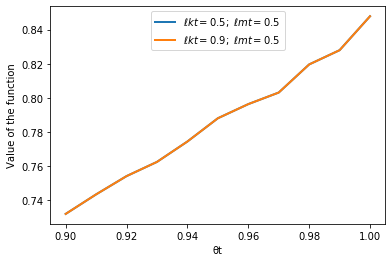

In [41]:
#s_propose
#variando lkt
fig, ax = plt.subplots()


#uso cut = ao maior lkt, assim não temos θkt acima de ℓkt
lkt1 = 0.5
lkt2 = 0.9
cut = max(lkt1, lkt2)
t = 0

graf_multi_func(hvals, t, 's', s_propose, ℓkt = lkt1, ℓmt = 0.5, cut = cut)
graf_multi_func(hvals, t, 's', s_propose, ℓkt = lkt2, ℓmt = 0.5, cut = cut)

plt.show()

fig.savefig('fig1', dpi=400, bbox_inches="tight")


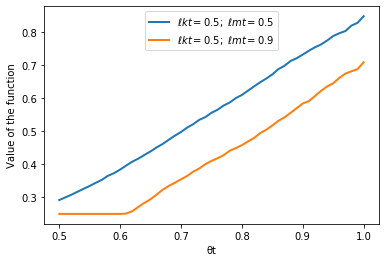

In [42]:
#s_propose
#variando lmt
fig, ax = plt.subplots()


#uso cut = ao maior lkt, assim não temos θkt acima de ℓkt
lkt1 = 0.5
lkt2 = 0.5
cut = max(lkt1, lkt2)
t = 0

graf_multi_func(hvals, t, 's', s_propose, ℓkt = lkt1, ℓmt = 0.5, cut = cut)
graf_multi_func(hvals, t, 's', s_propose, ℓkt = lkt2, ℓmt = 0.9, cut = cut)

plt.show()

fig.savefig('fig2', dpi=400, bbox_inches="tight")

Gráficos da função s_respond

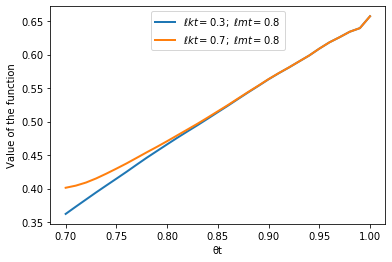

In [43]:
#s_respond
#variando lkt
fig, ax = plt.subplots()


#uso cut = ao maior lkt, assim não temos θkt acima de ℓkt
lkt1 = 0.3
lkt2 = 0.7
cut = max(lkt1, lkt2)
t = 0

graf_multi_func(hvals, t, 's', s_respond, ℓkt = lkt1, ℓmt = 0.8, cut = cut)
graf_multi_func(hvals, t, 's', s_respond, ℓkt = lkt2, ℓmt = 0.8, cut = cut)

plt.show()

fig.savefig('fig3', dpi=400, bbox_inches="tight")

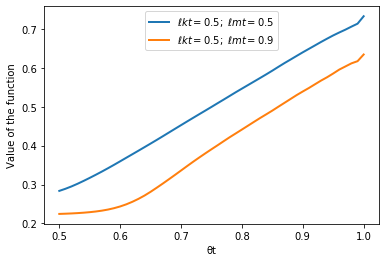

In [44]:
#s_respond
#variando lmt
fig, ax = plt.subplots()


#uso cut = ao maior lkt, assim não temos θkt acima de ℓkt
lkt1 = 0.5
lkt2 = 0.5
cut = max(lkt1, lkt2)
t = 0

graf_multi_func(hvals, t, 's', s_respond, ℓkt = lkt1, ℓmt = 0.5, cut = cut)
graf_multi_func(hvals, t, 's', s_respond, ℓkt = lkt2, ℓmt = 0.9, cut = cut)

plt.show()

fig.savefig('fig4', dpi=400, bbox_inches="tight")

Gráfico do valor de continuação

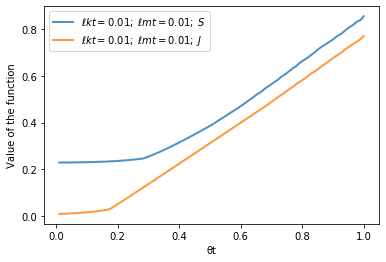

In [45]:
def graf_func_value(creditor, k_array, ℓkt, ℓmt, t):
    #t starts at t=1
    
    #size of X axis
    X = hvals


    #storing the function vals in t
    graf_vals = k_array[t, :, find(ℓkt), find(ℓmt)]

    ax.plot(X, graf_vals, linewidth = 2, linestyle = '-', alpha = 0.8, label = rf'$ℓkt = {ℓkt}; \;ℓmt = {ℓmt}; \; {creditor}$')
    
#     name = str(k_array)
#     title_val = print(name, 'ℓkt = ', ℓkt, 'ℓmt = ', ℓmt, 'period = ', t)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")


    #achei melhor no upper right
    ax.legend(loc = 'upper left')

    
fig, ax = plt.subplots()

t = 0
graf_func_value('S',s_W, ℓkt = 0.01, ℓmt = 0.01, t = t)

graf_func_value('J',j_W, ℓkt = 0.01, ℓmt = 0.01, t = t)

plt.show()
fig.savefig('fig5', dpi=400, bbox_inches="tight")

Gráfico das propostas ótimas

In [46]:

def graf_proposal(function, function_name, t, xlabel, ylabel):
    

    grid_graf = len(hvals)

    graf = np.empty((grid_graf, grid_graf))

    for i, θs in enumerate(hvals):
        for j, lj in enumerate(hvals):
            graf[i,j] = function(t, θs, θs, lj)[1]


    fig, ax = plt.subplots()

    cs1 = ax.contourf(hvals, hvals, graf.T, alpha=0.75)
    # ctr1 = ax.contour(hvals, lj_vals, graf1.T)
    # plt.clabel(ctr1, inline=1, fontsize=13)
    plt.colorbar(cs1, ax = ax)

    ax.set_title('Function ' + function_name +   ' in period ' + str(t) )
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

    ax.ticklabel_format(useOffset=False)


    plt.show()

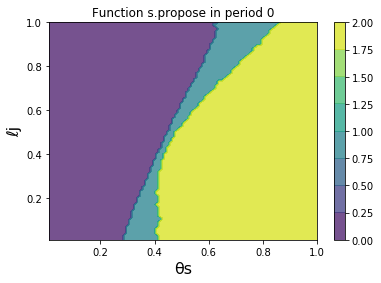

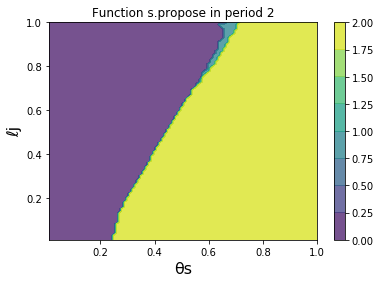

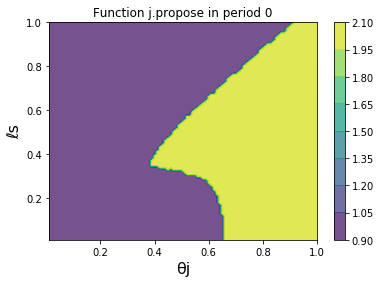

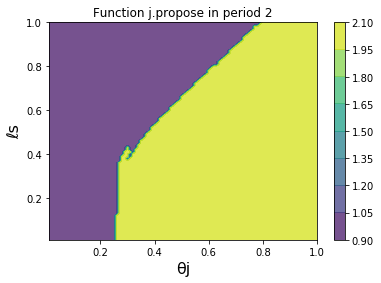

In [47]:
graf_proposal(s_propose,'s.propose', 0, 'θs', 'ℓj')
graf_proposal(s_propose,'s.propose', 2, 'θs', 'ℓj')

graf_proposal(j_propose, 'j.propose', 0, 'θj', 'ℓs')
graf_proposal(j_propose, 'j.propose', 2, 'θj', 'ℓs')

#### Checando função propose nos locais onde ela está estranha

def check_proposal(t, fixed_param, fixed_val, low, high, Pkt):
    #fixed parameter = lm or hk
    
    if(fixed_param == 'hk'):
        for i in range(find(low), find(high)):
            print(Pkt(t, fixed_val, hvals[i]), i)
        
        
    else:
        for i in range(find(low), find(high)):
            print(Pkt(t, hvals[i], fixed_val ), i)
    
    
#test
check_proposal(2, 'lm', 0.8, 0.4, 0.5, Pjt)

1) Valores de J em t = 2

lmt varia de 0.01 a 0.4, enquanto hk = 0.2

Conclusão: diferença na quarta casa decimal faz a proposta ficar estranha.

s_W[2, 9, 8, find(0.1)]

check_proposal(2, 'hk', 0.1, 0.01, 0.4, Pjt)